Instance : A-n32-k5
Camions utilisés : 14
Coût total        : 1812.70
Makespan (dernier camion) : 207.54
✅ Contraintes respectées : capacité + temps (attente autorisée)


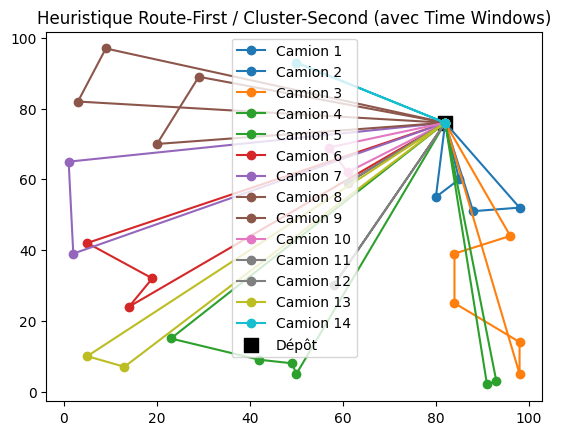

In [13]:
# ============================================================
# 1️⃣ IMPORTS
# ============================================================
import math
import matplotlib.pyplot as plt
import vrplib
import os
import numpy as np

# ============================================================
# 2️⃣ CHARGEMENT INSTANCE VRPLIB
# ============================================================
def load_vrplib_instance(name="A-n32-k5"):
    """
    📦 Lit une instance VRPLIB locale (compatible dict ou array)
    Ajoute ici aussi des fenêtres temporelles factices (si non fournies)
    """
    filename = f"{name}.vrp"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"❌ Le fichier {filename} est introuvable dans le dossier courant !")

    instance = vrplib.read_instance(filename)

    # Lecture compatible selon structure du fichier
    nodes = instance.get("node_coord", instance.get("node_coords"))
    demands = instance.get("demand", instance.get("demands"))
    Q = instance["capacity"]
    depot = instance.get("depot", [1])[0]

    # Conversion ndarray → dictionnaire
    if isinstance(nodes, np.ndarray):
        nodes = {i + 1: tuple(nodes[i]) for i in range(len(nodes))}
    if isinstance(demands, np.ndarray):
        demands = {i + 1: int(demands[i]) for i in range(len(demands))}

    if depot not in nodes:
        depot = 1

    customers = [i for i in nodes.keys() if i != depot]

    # Fonction distance euclidienne
    def dist(i, j):
        xi, yi = nodes[int(i)]
        xj, yj = nodes[int(j)]
        return math.hypot(xi - xj, yi - yj)

    # Fenêtres temporelles factices (si non présentes dans l'instance)
    # ⏰ Ici on simule des créneaux : chaque client a un [a_i, b_i]
    # pour illustrer la contrainte a_i ≤ t_i ≤ b_i
    time_windows = {i: (i * 2, i * 2 + 50) for i in customers}
    time_windows[depot] = (0, 10000)  # dépôt toujours ouvert

    # Temps de service (durée de livraison chez le client)
    service_time = {i: 5 for i in nodes.keys()}

    return nodes, customers, depot, demands, Q, dist, time_windows, service_time


# ============================================================
# 3️⃣ ROUTE-FIRST : tournée globale par Nearest Neighbor
# ============================================================
def nearest_neighbor_route(customers, depot, dist):
    """
    🔁 Construit une tournée complète (TSP global)
    - Respecte la contrainte de visite unique
    - Objectif : minimiser la distance totale (fonction objectif)
    """
    route = [depot]
    remaining = set(customers)
    current = depot
    while remaining:
        nxt = min(remaining, key=lambda c: dist(current, c))
        route.append(nxt)
        remaining.remove(nxt)
        current = nxt
    route.append(depot)
    return route


# ============================================================
# 4️⃣ CLUSTER-SECOND : découpe selon capacité + time windows
# ============================================================
def split_by_capacity_and_time(global_route, demands, Q, depot, dist, time_windows, service_time):
    """
    🧩 Découpe la tournée globale en sous-tournées faisables
    Respecte :
      ✅ Contrainte de capacité : somme(q_i) ≤ Q
      ✅ Contrainte de temps : a_i ≤ t_i ≤ b_i
      ✅ Attente autorisée si arrivée avant a_i
    """
    routes = []                 # liste de toutes les tournées (camions)
    current_route = [depot]     # tournée en cours
    current_load = 0            # charge actuelle
    current_time = 0            # temps d'arrivée courant

    for client in global_route[1:]:
        if client == depot:
            continue

        demand = demands[client]
        a_i, b_i = time_windows[client]  # fenêtre temporelle du client
        travel_time = dist(current_route[-1], client)

        # Temps d'arrivée prévu chez le client
        arrival_time = current_time + travel_time

        # Attente si arrivée trop tôt (fenêtre temporelle avancée)
        if arrival_time < a_i:
            waiting = a_i - arrival_time
            arrival_time = a_i  # attendre jusqu'à ouverture de la fenêtre
        else:
            waiting = 0

        leave_time = arrival_time + service_time[client]

        # 🚫 Si capacité ou fenêtre temporelle non respectée → nouveau camion
        if current_load + demand > Q or leave_time > b_i:
            current_route.append(depot)
            routes.append(current_route)
            # réinitialiser pour un nouveau camion
            current_route = [depot, client]
            current_load = demand
            current_time = a_i + service_time[client]  # début chez le nouveau client
        else:
            # ajout du client à la tournée actuelle
            current_route.append(client)
            current_load += demand
            current_time = leave_time

    current_route.append(depot)
    routes.append(current_route)
    return routes


# ============================================================
# 5️⃣ ÉVALUATION DES TOURNÉES
# ============================================================
def route_cost(route, dist):
    """💰 Fonction objectif : coût = somme des distances (τ_ij x_ijk)"""
    return sum(dist(route[i], route[i + 1]) for i in range(len(route) - 1))

def total_cost(routes, dist):
    """💰 Somme des coûts de toutes les tournées"""
    return sum(route_cost(r, dist) for r in routes)

def makespan(routes, dist):
    """⏱️ Date de retour du dernier camion (max des distances)"""
    return max(route_cost(r, dist) for r in routes)


# ============================================================
# 6️⃣ VISUALISATION
# ============================================================
def plot_solution(routes, coords, depot):
    """📊 Affiche les tournées sur le graphe"""
    cmap = plt.colormaps.get_cmap('tab10')
    for i, r in enumerate(routes):
        xs = [coords[n][0] for n in r]
        ys = [coords[n][1] for n in r]
        plt.plot(xs, ys, marker='o', color=cmap(i / len(routes)), label=f"Camion {i + 1}")
    plt.scatter(coords[depot][0], coords[depot][1],
                color='black', s=100, marker='s', label="Dépôt")
    plt.legend()
    plt.title("Heuristique Route-First / Cluster-Second (avec Time Windows)")
    plt.show()


# ============================================================
# 7️⃣ PIPELINE PRINCIPAL
# ============================================================
def route_first_cluster_second(name="A-n32-k5"):
    coords, customers, depot, demands, Q, dist, time_windows, service_time = load_vrplib_instance(name)

    # Étape 1 : tournée globale (Nearest Neighbor)
    global_route = nearest_neighbor_route(customers, depot, dist)

    # Étape 2 : découpe en tournées faisables (capacité + fenêtres)
    routes = split_by_capacity_and_time(global_route, demands, Q, depot, dist, time_windows, service_time)

    # Étape 3 : calculs de performance
    cost = total_cost(routes, dist)
    mksp = makespan(routes, dist)

    print(f"Instance : {name}")
    print(f"Camions utilisés : {len(routes)}")
    print(f"Coût total        : {cost:.2f}")
    print(f"Makespan (dernier camion) : {mksp:.2f}")
    print("✅ Contraintes respectées : capacité + temps (attente autorisée)")

    # Vérification de faisabilité (visite unique + capacité)
    visited = [v for r in routes for v in r if v != depot]
    assert set(visited) == set(customers), "❌ Tous les clients ne sont pas visités"
    for r in routes:
        load = sum(demands[v] for v in r if v != depot)
        assert load <= Q, f"❌ Capacité dépassée ({load} > {Q})"

    plot_solution(routes, coords, depot)
    return routes, cost, mksp


# ============================================================
# 8️⃣ TEST RAPIDE
# ============================================================
if __name__ == "__main__":
    route_first_cluster_second("A-n32-k5")
